#Semester Project


##Imports


In [142]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import deque, namedtuple
from IPython.display import clear_output
from matplotlib import colors
from scipy.io import loadmat
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import os.path


import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import numpy as np


import random
import pickle
import copy
import time
import math

In [143]:
from collections import deque, namedtuple
from torch.backends import cudnn
from torch.optim.lr_scheduler import StepLR
plt.style.use('ggplot')
cudnn.benchmark # Calling this optimizes runtime

False

##Utility Functions

###Init Functions


In [144]:
def creation_u(n_states, from_file=None):
  if from_file is not None and os.path.isfile(from_file):
    U = torch.load(from_file, map_location=DEVICE)
  else:
    # Creates a matrix u of related content
    U = torch.rand(n_states, n_states, device=DEVICE)
    ind = np.diag_indices(U.shape[0])
    U[ind[0], ind[1]] = torch.zeros(U.shape[0], device=DEVICE)
  # torch.save(U, 'U.pt')
  return U

def creation_caching(n_states, n_cached, from_file=None):
  """
  Returns a list which contains the cost to get a content
  It contains only 0 (cached) or 1 (non-cached)
  Create cost of 1 and then set n of them to 0 randomly
  """
  if from_file is not None and os.path.isfile(from_file):
    cost = torch.load(from_file, map_location=DEVICE)
  else:
    cost = torch.ones((n_states,), dtype=int, device=DEVICE) 
    cost[random.sample(range(0, n_states), n_cached)] = 0
  return cost


def create_priori_popularity(n_states, uniform=True) :
  """
  It creates a list of probability to get the content
  This is p_0 = [ p_0, ..., p_K-1]
  The sum should be one
  """
  if uniform : 
    result = (1/n_states) * np.ones((1,n_states))[0]
  else :
    result = [random.random() for i in range(1,n_states)]
    sum_r = np.sum(result)
    result = [i/sum_r for i in result]
    result = np.array(result)
  return result

def get_random_state(p0) :
  """ 
  Returns a random content among the contents
  """
  # too complicated with -> return random.randint(0, len(p0))
  state = [i for i in range(len(p0))]
  return np.random.choice(state,1,p0[0])[0]


def get_recommended(state, n_recommended, u) :
  """
  Returns the n_recommended content of the content 'state'
  For the moment we only return the most related contents
  """
  liste = u[state]
  not_null = len(torch.where(liste != 0)[0])
  indx = (-liste).argsort()[:min(not_null, n_recommended)]
  return indx


def get_matrix_rewards(env) :
  """
  Compute the reward for each state and action
  """
  q_table = np.zeros((env.n_states,env.n_actions))
  index_cached = np.where(env.get_index_cached() == 0)[0]
  index_recommended = env.get_index_recommendation()
  q_table[:,index_cached] += 1
  for index,x in enumerate(index_recommended) :
    q_table[index][x] +=1

  return q_table


def running_mean(x, N):
  """
  Return the running mean of an array
  """
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / N

###Plotting Functions

In [145]:
def plot_notated_matrix(matrix, title='Correlation Matrix', x_label=None, y_label=None, save_to_png=False, 
                 color_range='viridis', fig_size=(5, 5), lim=0.7, rotation_x=0, size_number=10, print_values=False):
  """
  Print a matrix and return the figure, axis and colorbar
  """
      
  fig, ax = plt.subplots(figsize=fig_size)
  im = ax.imshow(matrix, cmap=color_range)

  #Set names and grid
  size = matrix.shape[0]
  col_names = [c for c in range(size)]
  ax.set_xticks(np.arange(size))
  ax.set_yticks(np.arange(size))
  ax.set_xticklabels(col_names, rotation=rotation_x)
  ax.set_yticklabels(col_names)
  ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
  ax.grid(False)
  ax.tick_params(which="minor", bottom=False, left=False)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  # Remove edges
  for edge, spine in ax.spines.items():
      spine.set_visible(False)

  if print_values:
    #Add Values
    for i in range(size):
      for j in range(size):
        if matrix[i, j] > lim:
          col = 'black'
        else:
          col = 'w'
    
        text = ax.text(j, i, f'{matrix[i, j]:.2f}',
                            ha="center", va="center", color=col, fontsize=size_number)
      
  ax.set_title(title)

  #Color Bar
  cb = fig.colorbar(cm.ScalarMappable(norm=None, cmap=color_range), ax=ax, fraction=0.046, pad=0.04)
  cb.mappable.set_clim((int(torch.min(matrix)), math.ceil(torch.max(matrix))))
  
  fig.tight_layout()
  if save_to_png:
    plt.savefig(f"{title}.png", dpi=240)
  else:
    plt.show()
  
  return fig, ax, cb

In [146]:
def plot_array(x, figsize=(5,5),color_range='viridis', lim=0.7,size_number=10):
  plt.style.use('ggplot')
  fig, ax = plt.subplots(2, 1, figsize=figsize, sharey=False)
  _ = ax[0].bar(np.arange(len(x)), x)
  plt.sca(ax[0])
  #ax[0].set_xlim((-0.5,len(x)+.5))
  # ax[i].set_xlabel('Grades')
  # ax[i].set_ylabel('# Students')
  plt.xticks(np.arange(len(x)), np.arange(len(x)))
  x = np.expand_dims(x, axis=0)
  im = ax[1].imshow(x, cmap=color_range)
  plt.sca(ax[0])
  ax[1].grid(False)
  dif_ = np.max(x) - np.min(x)
  for j in range(x.shape[1]):
    if x[0, j] > (lim * dif_) + np.min(x):
      col = 'black'
    else:
      col = 'w'
    text = ax[1].text(j, 0, f'{x[0, j]:.2f}',
        ha="center", va="center", color=col, fontsize=size_number)
  col_names = [c for c in range(x.shape[1])]
  ax[1].set_xticks(np.arange(x.shape[1]))
  ax[1].set_yticks([])
  ax[1].set_xticklabels(col_names)
  ax[1].set_yticklabels([])

In [147]:
def plot_benchmark(x, y, figsize=(5,5),color_range='viridis', labels=['Agent'], title=None, lim=0.7,size_number=10):
  plt.style.use('ggplot')
  fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)

  pos = np.arange(len(x))

  _ = ax.bar(pos-.15, x, width=0.3, color='g', align='center', label='Average Reward')
  _ = ax.bar(pos+.15, y, width=0.3, align='center', label='Average Penalty')
  ax.legend()
  plt.sca(ax)
  ax.set_xticks(pos)
  ax.set_xticklabels(labels)
  if title is not None:
    ax.set_title(title)

In [148]:
def plot_difs(max_d, min_d, figsize=(5,5), color_range='viridis', labels=['Agent'], title=None, lim=0.7,size_number=10):
  plt.style.use('ggplot')
  fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)

  pos = np.arange(len(max_d))

  _ = ax.bar(pos-.15, max_d, width=0.3, color='r', align='center', label='Max Diff')
  _ = ax.bar(pos+.15, min_d, width=0.3, color='b', align='center', label='Mean Diff')
  ax.legend()
  plt.sca(ax)
  ax.set_xticks(pos)
  ax.set_xticklabels(labels)
  if title is not None:
    ax.set_title(title)
  else:
    ax.set_title("Q table difference with optimum")

In [149]:
def parse_time(seconds):
  sec = int(seconds)

  if sec >= 60:
    min = str(sec // 60)
    if len(min) != 2:
        min = "0" + min
    sec = sec % 60
  else:
    min = "00"

  sec = str(sec)
  if len(sec) < 2:
    sec = '0' + sec    

  if int(min) >= 60:
    hr = str(int(min) // 60)
    min = str(int(min) % 60)
    if len(min) < 2:
        min = '0' + min
    if len(hr) < 2:
        hr = '0' + hr 
  else:
    hr = '00'

  return f'{hr}:{min}:{sec}'

In [150]:
def parse_milis(seconds):
  sec = int(seconds)
  milis = int((seconds - sec) *1000)
  return f's{sec}m{milis}'

In [151]:
def plot_line_charts(reward, run_mean = 10, gammas = [0,0.9], name='Rewards',
                     figsize=(15, 5)) :
    
  """
  Plot the reward for different models

  ....

  Parameters
  -----------
    Reward : list of rewards
    Gammas : list of gammas used
    Run_mean : size of the window to average
  """

  colors = ['r','b','g', 'p']
  plt.figure(figsize=figsize)
  for index, gamma in enumerate(gammas) : 
      
    smoothed_rews = running_mean(reward[index], run_mean)
    
    
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.plot(smoothed_rews,\
            label = r'{}, running mean : {}'.format(gamma,run_mean))
      
      
  plt.legend()
  plt.title('{} for different models'.format(name))
  plt.grid(True)
  plt.show()

## Benchmark Agents



### Random Agent

In [152]:
'''
Agent class that always recommend a randomized item:
no learning here!

Used to get the mean reward in order to compare with our RL mean reward
Compare also costs and length of episodes
'''

class Randomic_choice:
  def __init__(self, n_states, n_actions):
    self.n_actions = n_actions
    self.n_states = n_states
    self.max_iter = max_iter
  

  def choose_action(self, state):
    action = random.randint(0, self.n_actions-1) 
    return action          

### Most N correlated Agent

In [153]:
'''
Agent class that always recommend a correlated item: no learning here!

Used to get the mean reward (should be 1)in order to compare with our RL mean reward 
Compare also costs
'''
class MostCorrelated:
  def __init__(self, n_states, n_actions, env):
    self.n_actions = n_actions
    self.n_states = n_states
    self.max_iter = max_iter
    self.env = env

  def choose_action(self, state):
    recommended_contents =  self.env.recommended[state]
    index_state = random.randrange(0, len(recommended_contents), 1)
    action = recommended_contents[index_state]           
    return action          

###Tabular Agent


In [154]:
class TabularAgent:
  """ 
  ...

  Attributes
  ----------
  n_actions: int
      number of possible actions
  n_states: int
      number of possible states
  q_table: array([n_states, n_actions])
      array containing values for all states-action pair
  alpha : float
      learning_rate, determines to what extent newly acquired information overrides old information
  gamma : float
      discount_factor, determines the importance of future rewards
  eps : float
      probability of exploitation instead of exploration
  start_decay : int 
      Episode on which epsilo decay should start 
  end_decay : int 
      episode till which decay should continue
  epsilon_decay_value : float 
      Value by which wpsilon should be decayed every episode
  eps_min : float 
      lower bound on the epsilon value

  Methods
  -------
  choose_action(state)
      Choose next action with an epsilon-greedy policy
     
  choose_action_rec(state, env )
      Choose next action from recommendations with an epsilon-greedy policy
  
  learn(state, action, reward, next_state)
      Update the q_table
  
  plot_q_table()
      Plot q table heatmap
      
  decay_epsilon(episode)
      decay the epsilon value based on defined attributes


  """
    
  def __init__(self, n_states, n_actions, gamma=0.9, eps=0.9, alpha=0.6, 
               start_decay=0, end_decay=10000, eps_min=0):
    self.n_actions = n_actions
    self.n_states = n_states
    self.q_table = np.zeros([env.n_states, env.n_actions])
    self.alpha = alpha
    self.gamma = gamma
    self.eps = eps
    self.train_data = None

    # Epsilon Decay parameters 
    self.start_decay = start_decay
    self.end_decay = end_decay
    self.eps_min = eps_min
    self.epsilon_decay_value = (eps-eps_min)/abs(self.end_decay - self.start_decay)

  def choose_action(self, state):
    """
    Parameters
    ----------
    state : int, current state of the environment
    Returns
    -------
    action: int, action taken given the current state and an e-greedy policy
    
    """

    if random.uniform(0, 1) < self.eps:
      # Explore action space
      action = random.randint(0, self.n_actions-1) 
      while action == state:
        action = random.randint(0, self.n_actions-1) 
    else:
      # Exploit learned values
      action = np.argmax(self.q_table[state])
    return action
    
    
  def learn(self, state, action, next_state, reward):
    """
    Update the q_table
    
    ...
    
    Parameters
    ----------
    state: int, current state of the environment
    action: int, action taken
    reward: float, reward obtained given state-action
    next_state: int, next_state of the environment
    """
    
    old_value = self.q_table[state, action]
    next_max = np.max(self.q_table[next_state])
    
    new_value = (1 - self.alpha)* old_value + self.alpha * (reward + self.gamma * next_max)
    self.q_table[state,action] = new_value

    return (old_value - new_value)**2

  # Printing the Q-table with states
  def plot_q_table(self, notated=False, **kwargs):
    """
    Plot q table heatmap
    
    ...
    """
    if notated:
      _,_,_ = plot_notated_matrix(torch.from_numpy(self.q_table), x_label="Actions", y_label="States", title="Q table", **kwargs)

    else:
      ax = plt.subplot(111)
      im = ax.imshow(self.q_table)

      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      plt.ylabel("States")
      plt.xlabel("Actions")
      plt.title("Q table")
      plt.colorbar(im, cax=cax)

      plt.show()

  def get_q_table(self) :
    return self.q_table.copy()

  def decay_epsilon(self, episode):
    """
    Decaying is being done every episode if episode number is 
    within decaying range
    """
    if episode >= self.start_decay and episode <= self.end_decay:
      self.eps -= self.epsilon_decay_value
      if (self.eps < self.eps_min):
        self.eps = self.eps_min
    return 
      

### MDP UtopyAgent

In [155]:
from itertools import product as tuples

class UtopyAgent(object):
  def __init__(self, env, gamma=.9, max_iter=100, alpha=0.1, tol=1e-5):
    self.env = env
    self.gamma = gamma
    self.max_iter = max_iter
    self.tol = tol
    self.alpha=alpha

    self.all_state_action = list(tuples(range(self.env.n_states), repeat=2))


    self.q_table = torch.zeros(self.env.n_states, self.env.n_states)
    self.rewards = torch.zeros(self.env.n_states, self.env.n_states)
    self.popuate_rewards()

    self.max_updates = []
    self.max_loss = []
    self.eps = None

  def learn(self):
    sa = self.alpha
    for t in range(self.max_iter):
      if t % 500 == 0:
        self.alpha *=0.3 
      freez = self.q_table.clone()
      for i, j in self.all_state_action:
        # 
        if i == j:
          continue
        old_value = freez[i, j]
        new_state, reward, done = self.env.step(j, i)
        next_max = max(freez[new_state])

        self.q_table[i, j] = (1 - self.alpha)* old_value + self.alpha * (reward + self.gamma * next_max)
      
      self.max_updates.append(torch.max(torch.abs(self.q_table - freez)))
      self.max_loss.append(self.max_updates[-1]**2)
      
      if t % 1000 == 0:
        print(f"Iteration {t} finished. Max Loss: {self.max_loss[-1]}")
      if self.max_updates[-1] < self.tol:
        print("Convergence")
        break
    self.print_q_table()
    self.alpha = sa

  def popuate_rewards(self):
    for i, j in self.all_state_action:
      self.rewards[i,j] = self.env.find_reward(self.env, action=j, state=i)

  def print_reward_matrix(self):
    _ = plot_notated_matrix(self.rewards,  fig_size=(10, 10), print_values=True)

  def print_q_table(self):
    _ = plot_notated_matrix(self.q_table,  fig_size=(10, 10), print_values=True)

  def choose_action(self, state):
    action = torch.argmax(self.q_table[state])
    return action

  def get_q_table(self):
    return self.q_table

In [156]:
def test_tabular(run_mean=10, max_iter=100000, grap=True, agent_params={}):
  value_agent = TabularAgent(**agent_params)
  time_train, episodes, steps, delta_updates, avg_rw, avg_pen, avg_loss = update_t(env, value_agent, max_iter = max_iter, threshold = threshold, verbose=None)
  print("Total number of episodes: ", episodes)
  print("Time to train: ", parse_time(time_train))
  print(f'Average episode size: {np.mean(steps):.2f}, Standard Deviation: {np.std(steps):.2f} and Maximum steps per episode of: {np.max(steps)}')
  if(grap):
    #value_agent.plot_q_table(notated=True, fig_size=(12, 12), print_values=True)
    plot_line_charts([avg_rw], run_mean = run_mean, gammas = [0],name = 'Reward')
    plot_line_charts([avg_pen], run_mean = run_mean, gammas = [0],name = 'Penalty')
    plot_line_charts([avg_loss], run_mean = run_mean, gammas = [0],name = 'Loss')
    plot_line_charts([delta_updates],run_mean = run_mean, gammas = [0],name = 'Updates')
    #value_agent.plot_exp_distribution(figsize=(10,5))

  return value_agent

In [157]:
def update_t(env, agent, max_iter = 1000, threshold = 0.1, verbose=None):
  """
  
  ...
  
  Parameters
  ---------
  env: Environment
  agent: Agent
  max_iter: int, max number of episodes
  threshold: float, minimum difference to stop algorithm
  v1: bool, Variable to set selection from recommendation slate

  Returns
  -------
  time_train: time to execute the method
  episodes: total number of episodes runned 
  steps: steps performed for each episode
  delta_updates: differences of errors between two episodes
  all_rewards: Accumulated Rewards 
  all_penalties: Accumulated penalties, defined as negative rewards
  
  """
  
  # Number of steps per episode
  steps = []
  
  # Max error of all episodes
  delta_updates = []
  
  max_diff = threshold + 1
  episodes = 0
      
  before_time = time.time()
  
  all_rewards = []
  all_penalties = []
  all_losses = []

  benchmarks = [0]

  for episodes in tqdm(range(max_iter)):
    if verbose is not None and episodes % verbose == 0:
        agent.plot_q_table(notated=True, fig_size=(10, 10), print_values=True)        
    # We copy the first step of the table to compare at the end
    old_q_table = agent.get_q_table()
    
    # Initialize the state
    state = env.refresh()
    i = 0
    
    done = False
    
    # Teacker for rewards and penalties
    current_reward = 0
    current_penalty = 0
    current_loss = 0
    while not done:
      # The agent takes an action
      action = agent.choose_action(state)
      next_state, reward, done = env.step(action, state)     
      current_loss += agent.learn(state, action, next_state, reward)

      #if ( (next_state is None) or (action is None)  ) :
          # We stop when the user leaves the process
      #    break
      
      # Go to the next state
      state = next_state
      # Calculating number of Steps in the current Episode
      i += 1
      # Append the Reward
      current_reward += reward
      # Define the penalty for negative rewards
      if reward <= env.rewards[2] : 
          current_penalty +=1
    
    
    # RL learns from this transition

    steps += [i]
    new_q_table = agent.get_q_table()
    delta_update = (abs(new_q_table - old_q_table)).max()
    delta_updates.append(delta_update)
    old_q_table = new_q_table

    # Append the rewards and Penalties
    if i != 0:
      all_losses.append(current_loss / i)# if i != 0 else current_loss)
      all_penalties.append(current_penalty / i)# if i != 0 else current_penalty)
      all_rewards.append(current_reward / i)# if i != 0 else current_reward)
              
    # Update the max_diff every 1000 episodes
    if episodes > 0 and episodes % 1000 == 0:
      bn_rewards, _, _ = benchmark(env=env, agents=[agent], epochs=100, verbose=False)
      benchmarks.append(bn_rewards[0])
      if benchmarks[-1] > 1 and benchmarks[-2] - threshold < benchmarks[-1] < benchmarks[-2] + threshold:
        break
    #if episodes % 1000 == 0 :
        #print(episodes, " / ", max_iter)
        #clear_output(True)
    agent.decay_epsilon(episodes)    
  time_train =  time.time() - before_time

  agent.train_data = {
    'TrainTime': time_train,
    'Episodes':episodes + 1,
    'Steps': steps,
    'DeltaUpdates': delta_updates,
    'Rewards': all_rewards,
    'Penalties': all_penalties,
    'Losses': all_losses
  }
  return time_train, episodes + 1, steps, delta_updates, all_rewards, all_penalties, all_losses



## The Environment

methods set for single param recommended

In [158]:
class Environment(object) :
  """
  Creates an environmnent
  For us, this is the behavior of the User
  2 types of user ->  random -> alpha is coefficient to choose recommended content
                  ->  qualityAware -> aplha is the quality threshold for accepting the recommended content
  
  2 types of reward ->  'constant': the reward is exactly what is specified in the rewards paramete
                    ->  'variable': the reward is computed taking in account the correlation value
  
  """ 
          
  def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
              rewards,SEED=5, u=None, user_type='random', reward_type='constant') :
    self.SEED = SEED
    self.n_states = n_states
    self.n_actions = n_actions
    # Alpha is the coefficient in which a user chooses a recommended content
    self.alpha = alpha
    # to_leave is the coefficient in which a user decides to quit the process
    self.to_leave = to_leave
    # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
    self.n_recommended = n_recommended
    # n_cached correponds to the number of cached content
    self.n_cached = n_cached
    # U matrix which denotes the similarity score
    self.u = creation_u(self.n_states) if u is None else u  
    # It denotes the cached content (0 if cached, 1 not-cached)
    self.cost = creation_caching(self.n_states, self.n_cached)
    # The probability to choose content j from the catalogue
    self.p0 = create_priori_popularity(self.n_states)
    
    self.recommended = self.get_index_recommendation()
    self.user_type = user_type
    
    self.rewards = rewards
    # List of rewards like [RC, RnC , nRC, nRnC]
    # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
    self.reward_type = reward_type

    #self.is_cached =  1 - self.cost => used to faster find the cached states
    self.is_cached =  torch.ones_like(self.cost) - self.cost

    # Type of reward used. 
    # 'constant': the reward is exactly what is specified in the rewards paramete
    # 'variable': the reward is computed taking in account the correlation value
    if (reward_type not in self.reward_types):
      raise Exception('Invalid reward type')
    self.find_reward = self.reward_types[reward_type]


  def refresh(self, SEED=None):
    """Reset the state to a new value """
    if SEED is not None:
      self.SEED = SEED
    return random.randrange(0, self.n_states, 1)
    

  def reset(self):
    """
    Reset the environment to a new random state. 
    It resets both the recommendation and the cached indexes
    It returns a first state
    """
    self.u = creation_u(self.n_states)
    self.cached = creation_caching(self.n_states, self.n_cached)
    self.p0 = create_priori_popularity(self.n_states)

    return self.state[random.randrange(0,self.n_states,1)]  
    

  def find_constant_reward(self, action, state):      
    """
    Finds the reward for the given action starting in the given state 
    It tests whether the state is recommended, cached or not
    """
        
    # # It gives from the u matrix whether the action from the state is recommended or not 
    # if ((state is None) or (action is None) ):
    #     return None
    
    recommended_matrix = self.recommended[state]
    is_cached = self.is_state_cached(action)
    
    if (action in recommended_matrix) and (is_cached):
      # Content recommended and cached : best reward
      return self.rewards[0]
    elif (action in recommended_matrix) and (not is_cached):
      # Content recommended but not cached
      return self.rewards[1]
    elif (action not in recommended_matrix) and (is_cached):
      # Content not recommended but cached
      return self.rewards[2]
    else :
      # Content neither recommended nor cached
      return self.rewards[3]

  def find_variable_reward(self, action, state):
    """
    Finds the reward for the given action starting in the given state 
    Given the reward array [RC, RnC , nRC, nRnC]
    It is computed as a sum of partial rewards depending on the state-action
      correlation and if the action is cached. The reward can not exceed RC 
    """
    # if ((state is None) or (action is None) ):
    #   return None
    reward = self.rewards[-1]

    correlated = self.recommended[state]

    if self.is_state_cached(action):
      reward += self.rewards[2]
    # if action in correlated:
    reward += (self.rewards[1] * self.u[state, action])
    # else:
    #   reward -=.2
    #   reward = max(reward, 0)
    return float(reward)

  #Implementation with a single reccomandation by now
  def step(self, action, state):
    """ 
    Returns the state, reward after taking the action in input
    - done is a boolean to say whether the user quits the game or not
    We want to return the state where will be the user when we suggest him "action"
    Knowing he is in the current 'state'
    """
    if (random.uniform(0, 1) < self.to_leave) :
      # The user stops to play
      reward = self.find_reward(self, action=action, state=state)
      new_state, reward, done = action, reward, True
      return new_state, reward, done
    else :
      # The user will choose among the contents
      if (self.user_type == 'random'):
        # random user -> probability alpha to follow reccommendation, but check that action != state
        if (random.uniform(0,1) < self.alpha and action != state):
          # Then the user chooses a content among the recommended contents
          new_state = action
          reward = self.find_reward(self, action=action, state=state)
        else :
          # The user picks a content randomly in the catalogue
          new_state = get_random_state(self.p0)
          while new_state == state:
            #check to avoid self loop
            new_state = get_random_state(self.p0)
          reward = self.find_reward(self, action=action, state=state)

      elif (self.user_type == 'qualityAware'):
        #check if item proposed is valuable, then accept it if over a threshold
        # if more reccomandations, use the mean/smth else
        if (self.u[state,action]>self.alpha):
          #here check for self-loop not required, qtable with 0 as diagonal
          new_state = action
          reward = self.find_reward(self, action, state)
        else :
          # The user picks a content randomly in the catalogue
          new_state = get_random_state(self.p0)
          while new_state == state:
              #check to avoid self loop
              new_state = get_random_state(self.p0)
          reward = self.find_reward(self, action, state)
    done = False
    return new_state, reward, done
    
  def get_index_recommendation(self):
    """
    Returns a matrix with all index of recommended content
    """
    recommended = []
    for state in range(self.n_actions):
      recommended.append(get_recommended(state, self.n_recommended, self.u))
    return recommended
    
  def get_index_cached(self):
    return self.cost
    
  def is_state_cached(self, state):
    """
    Takes as input a state and the cost matrix (where Xi = 0 if cached and 1 if not-cached)
    Returns a boolean which says whether or not it is cached or not
    """
    return self.cost[state] == 0

  def save_env(self, env_path='env.pt'):
    torch.save({
            'U': self.u,
            'cost': self.cost,
            'n_states': self.n_states,
            'n_actions':  self.n_actions,
            'SEED': self.SEED,
            'alpha': self.alpha,
            'to_leave':self.to_leave,
            'n_recommended': self.n_recommended,
            'n_cached':self.n_cached,
            'p0': self.p0,
            'user_type': self.user_type,
            'rewards': self.rewards,
            'reward_type': self.reward_type,
            }, env_path)
    
  def load_env(self, env_path=None):
    if env_path is not None and os.path.isfile(env_path):
      checkpoint = torch.load(env_path)
      self.u = checkpoint['U'] 
      self.cost = checkpoint['cost'] 
      self.n_states = checkpoint['n_states'] 
      self.n_actions = checkpoint['n_actions'] 
      self.SEED = checkpoint['SEED'] 
      self.alpha = checkpoint['alpha'] 
      self.to_leave = checkpoint['to_leave']
      self.n_recommended = checkpoint['n_recommended'] 
      self.n_cached = checkpoint['n_cached']
      self.p0 = checkpoint['p0'] 
      self.recommended = self.get_index_recommendation()
      self.user_type = checkpoint['user_type'] 
      self.rewards = checkpoint['rewards']
      self.reward_type = checkpoint['reward_type']
      self.is_cached = torch.ones_like(self.cost) - self.cost


    else:
      print(f"no file {env_path} found!")
    
    return self

  reward_types = {
          'constant': find_constant_reward,
          'variable': find_variable_reward
  }  

##State Action Representation

In [159]:
class ConversionStateAction(object) :
  """
  Class that is used to convert state and action into a new representation
  """

  def corr_chache_encoding(self, state):
    correlation_state = self.env.u[state] # [k]
    is_action_cached = self.env.is_cached # [k]
    return torch.cat((correlation_state.view(-1,1), is_action_cached.view(-1,1)), 1) 

  def corr_chache_dim(self):
    return 2

  def miriam_encoding(self, state): # result waited = [kx3]
    correlation_state = self.env.u[state] # [k]
    is_action_cached = self.env.is_cached # [k]
    normalizers = torch.ones_like(is_action_cached)*self.env.n_cached - self.env.is_cached # [k]
    nums = torch.sum(self.env.is_cached[self.n_most], dim=1) # [k]
    nacc = nums / normalizers # [k]

    return torch.cat((correlation_state.view(-1,1), is_action_cached.view(-1,1), nacc.view(-1,1)), 1) 

  def miriam_dim(self):
    return 3


  def reborn_encoding(self, state): # result waited = [kx3]
    correlation_state = self.env.u[state] # [k]
    is_action_cached = self.env.is_cached # [k]
    max_future = self.fixed_rebon.clone()

    return torch.cat((correlation_state.view(-1,1), is_action_cached.view(-1,1), max_future.view(-1,1)), 1) 

  def reborn_dim(self):
    return 3

    
  possible_representations = {
    'corr_chache' : corr_chache_encoding,
    'miriam': miriam_encoding,
    'reborn': reborn_encoding
  }

  state_dim_dict = {
    'corr_chache' : corr_chache_dim,
    'miriam': miriam_dim,
    'reborn': reborn_dim
  }

  features_per_model = {
    'corr_chache': [
                        'Correlation state-action',
                        'Action is cached',
    ],
    'miriam': [
                        'Correlation state-action',
                        'Action is cached',
                        'Number of actions that are in the most correlated and also cached \n of the current action normalized over the number of cached actions'
    ],
    'reborn': [
               'Correlation state-action',
                        'Action is cached',
               'Black Magic'
    ]
  }

  def __init__(self, total_states, env, reppresentation='miriam', N=None):    
    if N is None:
      self.N = env.n_recommended# int(total_states**.5) 
    else:
      self.N = N

    self.total_states = total_states
    self.env = env
    # optimization parameters 
    self.n_most = torch.argsort(-self.env.u, axis=1)[:,:self.N]
    m, _  = torch.max(env.u, dim=1)
    self.fixed_rebon = self.env.is_cached[self.n_most[:,0]] + m
    # self.cached_states = set()
    # for i, j in enumerate(self.env.cost):
    #   if j == 0:
    #     self.cached_states.add(i)

    if reppresentation not in self.possible_representations:
      print(f'WARNING: {reppresentation} does not exist')
      print(f'STATE representation SET TO all_features')
      self.reppresent_function = self.possible_representations['miriam']
      self.state_dim = self.state_dim_dict['miriam'](self)
    else:
      self.reppresent_function = self.possible_representations[reppresentation]
      self.state_dim = self.state_dim_dict[reppresentation](self)

    self.all_state_action = None
    self.populate()

        
  def __call__(self, state_action, all=False):
    """
    Parameters
    ----------
    state : int, list<int>
    different_repp
        define a different state representation function 
    """
    
    if all:
      return self.all_state_action
        
    
    if len(state_action) == 1: # one state -> all actions
      # Return all actions representations for the given state
      start_idx = state_action[0] * self.total_states
      end_idx = start_idx + self.total_states
      return self.all_state_action[start_idx:end_idx]
    else:
      # Return state-action representation
      return_value = self.all_state_action[state_action[0] * self.total_states + state_action[1]]
      return return_value

  def equal_s_a(self): # representation of all state actions
    states = np.arange(self.total_states)
    idx = states * self.total_states + states
    return self.all_state_action[idx]

  def populate(self):
    print("Creating Features Representations")
    all_state_action = []
    idx = 0
    for state in tqdm(range(self.total_states)):
      all_state_action.append(self.reppresent_function(self, state))
    self.all_state_action = torch.cat(all_state_action, 0)
    if self.state_dim == 3:
      m = torch.max(self.all_state_action[:,2]).item()
      self.all_state_action[:,2] = self.all_state_action[:,2] / m


## Q Learning Train Algorithm


In [160]:
def train(env, agent, max_iter = 1000, threshold = 0.1, verbose=None):
  """
  ...
  
  Parameters
  ---------
  env: Environment
  agent: Agent
  max_iter: int, max number of epochs
  threshold: float, minimum difference to stop algorithm
  verbose: int, print q_table each max_iter / verbose epochs

  Returns
  -------
  time_train: time to execute the method
  episodes: total number of episodes runned 
  steps: steps performed for each episode
  delta_updates: differences of errors between two episodes
  all_rewards: Accumulated Rewards 
  all_penalties: Accumulated penalties, defined as negative rewards
  all_losses: Accumulated losses of the train of the agent
  """
    
  # Number of steps per episode
  steps = []
  
  # Max error of all episodes
  delta_updates = []
  
  max_diff = threshold + 1
  episodes = 0
      
  before_time = time.time()
  
  all_rewards = []
  all_penalties = []
  all_losses = []

  benchmarks = [0]

  for episodes in tqdm(range(max_iter)):
    if verbose is not None and episodes % verbose == 0:
        agent.plot_q_table(notated=True, fig_size=(10, 10), print_values=True)        
    # We copy the first step of the table to compare at the end
    old_q_table = agent.get_q_table()
      
    # Initialize the state
    state = env.refresh()
    i = 0
      
    done = False
    
    # Teacker for rewards and penalties
    current_reward = 0
    current_penalty = 0
    current_loss = 0
    while not done:
      # The agent takes an action
      action = agent.choose_action(state)
      next_state, reward, done = env.step(action, state)     
      current_loss += agent.learn(state, action, next_state, reward)

      #if ( (next_state is None) or (action is None)  ) :
          # We stop when the user leaves the process
      #    break
      
      # Go to the next state
      state = next_state
      # Calculating number of Steps in the current Episode
      i += 1
      # Append the Reward
      current_reward += reward
      # Define the penalty for negative rewards
      if reward <= env.rewards[2] : 
        current_penalty +=1
      
      
      # RL learns from this transition

      steps += [i]
      new_q_table = agent.get_q_table()
      delta_update = (abs(new_q_table - old_q_table)).max()
      delta_updates.append(delta_update)
      old_q_table = new_q_table

    # Append the rewards and Penalties
    if i != 0:
      all_losses.append(current_loss / i)# if i != 0 else current_loss)
      all_penalties.append(current_penalty / i)# if i != 0 else current_penalty)
      all_rewards.append(current_reward / i)# if i != 0 else current_reward)
              
    if episodes > 0 and episodes % 1000 == 0:
      bn_rewards, _, _ = benchmark(env=env, agents=[agent], epochs=100, verbose=False)
      benchmarks.append(bn_rewards[0])
      if benchmarks[-1] > 1 and benchmarks[-2] - threshold < benchmarks[-1] < benchmarks[-2] + threshold:
        break
    agent.decay_epsilon(episodes)
    #agent.scheduler.step()

  time_train =  time.time() - before_time
  agent.train_data = {
      'TrainTime': time_train,
      'Episodes':episodes + 1,
      'Steps': steps,
      'DeltaUpdates': delta_updates,
      'Rewards': all_rewards,
      'Penalties': all_penalties,
      'Losses': all_losses
  }
  return time_train, episodes + 1, steps, delta_updates, all_rewards, all_penalties, all_losses



In [161]:
def loop_gamma(env, convert_state, model, gammas=[0, 0.9], lr=0.6, \
    epsilon=0.1, max_iter=50000, v1 = False, threshold=1e-4, train=train) : 
    """
    Function to loo through multiple discount factors

    Parameters
    ---------
    env: Environment
    convert_state: state conversion used
    gammas: List of discount factors
    alpha: Learning rate
    epsilon: exploration parameter
    max_iter: int, max number of episodes
    v1: bool, Variable to set selection from recommendation slate
    threshold: float, minimum difference to stop algorithm
    
    Returns
    -------
    rewards: Array with accumulated rewards for all discount factors
    penalties: Array with accumulated penalties for all discount factors
    losses: Array with accumulated penalties for all discount factors
    """

    # Initialize lists for storing rewards and penalties for multiple gammas
    rewards, penalties, losses = [], [], []
    
    for g in gammas : 

      # Create an agent for the gamma values   
      agent = Agent(n_states=env.n_states, n_actions=env.n_actions, convert_state=convert_state, model=model, lr=1e-3, gamma = 0, eps=epsilon)
      
      # Train the agent and get the accumulated rewards and penalties 
      _, _, _, _, rew, pen, loss = train(env, agent, max_iter = max_iter, threshold = threshold)
      
      #Append the accumulated rewards and penalties
      rewards.append(rew)
      penalties.append(pen)
      losses.append(loss)
    
    return rewards, penalties, losses

##Test Function

In [162]:
def test_q_table(optimum_agent, agents, names, fig_size=(15, 5)):
  o_q = optimum_agent.get_q_table().clone()

  max_dif = []
  min_dif = []
  max_dif_sa = []
  min_dif_sa = []
  for a in agents:
    t_q = a.get_q_table()
    ind = np.diag_indices(t_q.shape[0])
    t_q[ind[0], ind[1]] = torch.zeros(t_q.shape[0], device=DEVICE)
    

    d = torch.abs(o_q-t_q).float()
   
    print(f'{a} --- {torch.mean(d)}')
    max_sa = torch.argmax(d)
    max_state = int(max_sa % t_q.shape[0])
    max_action = int(max_sa // t_q.shape[0])
    max_dif_sa.append(f'State: {max_state} Action: {max_action}')
    max_dif.append(torch.max(d))

    d[ind[0], ind[1]] = torch.ones(t_q.shape[0], device=DEVICE).float()
    min_sa = torch.mean(d)
    min_state = int(min_sa % t_q.shape[0])
    min_action = int(min_sa // t_q.shape[0])
    min_dif_sa.append(f'State: {min_state} Action: {min_action}')
    

  plot_difs(max_d = max_dif, min_d = min_dif, labels=names, figsize=fig_size)
  return max_dif_sa, min_dif_sa

## Benchmark loop

In [163]:
def benchmark(env, agents, epochs = 100, verbose=False):
  """
  ...
  
  Parameters
  ---------
  env: Environment
  agents: list of agents
  epochs: int, max number of epochs

  Returns
  -------
  rewards: List with average rewards for each agent
  penalties: List with average penalty for each agent
  actions_choosen: List with percantage of choosing actions for each agent
  """
  
  rewards = []
  penalties = []
  actions_choosen = []
  
  for agent in agents:
    old_eps = agent.eps
    agent.eps = 0  
    tot_reward = 0
    tot_penalties = 0
    total_iterations = 0
    action_choosen = np.zeros(env.n_actions)

    for i in range(epochs):    
      # Initialize the state
      state = env.refresh()
      done = False
      if (verbose):
          print("Starting epoch ", i)
      while (not done): 
        total_iterations += 1

        action = agent.choose_action(state)   
        next_state, reward, done = env.step(action, state)

        if (verbose):
            print(f"{state} -- {action} -- {reward} -- {next_state}")
        
        state = next_state

        # Append the Reward
        tot_reward += reward

        # Define the penalty for negative rewards
        if reward <= env.rewards[2] : 
            tot_penalties += 1
        
        action_choosen[action] += 1
            
    agent.eps = old_eps
    rewards.append(tot_reward / total_iterations)
    penalties.append(tot_penalties / total_iterations) 
    actions_choosen.append(action_choosen / total_iterations)
  return rewards, penalties, actions_choosen

## Models


In [164]:
''' Linear Model '''

class LinearModel(nn.Module) :
  ''' Linear Model '''

  def __init__(self, state_dim , n_actions, names, load=False):
    """
    Inputs :
    state_dim : The size of the states
    n_actions : The number of actions in the catalogue (i.e the output of the NN)
    """
    super().__init__()

    # Fully connected layer for the ouput
    self.output = nn.Linear(state_dim, n_actions)
    
    if load:
      self.output.weight.data =torch.tensor([1.56, 0.98, 0.27], device=DEVICE).view(1,-1)
      self.output.bias.data = torch.tensor([14.8], device=DEVICE)
    self.f_names = names

  def forward(self, x) :
    # Forward action to predict the outputs
    x = self.output(x)
    return x

  def plot_weights(self, size=1, abs_w=True, color_range='viridis', lim=0.7, title=None, bias=True):
    x  = self.output.weight.data
    names = self.f_names

    if bias:
      names.append('Bias')
      x = torch.cat((x, self.output.bias.data.view(1,-1)), axis=1)
    if abs_w:
      x  = abs(x)
    x = x.cpu()
    figsize = (10 * size, 5 * size)
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(nrows=3, ncols=3, wspace=-.3 )
    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[:,1:])

    im = ax1.imshow(x.T, cmap=color_range)
    ax1.grid(False)
    dif_ = torch.max(x) - torch.min(x)
    font_size = figsize[1] *3
    for j in range(x.shape[1]):
      if x[0, j] > (lim * dif_) + torch.min(x):
        col = 'black'
      else:
        col = 'w'
      text = ax1.text(0, j, f'{x[0, j]:.2f}',
          ha="center", va="center", color=col, fontsize=font_size)
    ax1.set_xticks([])
    ax1.set_yticks(np.arange(x.shape[1]))
    ax1.set_yticklabels(names)

    ax2.barh(np.arange(x.shape[1]-1,-1,-1), x[0], label='Feature Weights')
    ax2.set_yticks([])
    ax2.set_ylim((-0.5,x.shape[1]-.5))
    ax2.legend()

    if title is not None:
      fig.suptitle(title, fontsize=font_size*2)

## Agent

In [165]:
class Agent:
  """ 
  ...

  Attributes
  ----------
  n_actions: int
      number of possible actions
  n_states: int
      number of possible states
  q_table: array([n_states, n_actions])
      array containing values for all states-action pair
  alpha : float
      learning_rate, determines to what extent newly acquired information overrides old information
  gamma : float
    discount_factor, determines the importance of future rewards
  eps : float
    probability of exploitation instead of exploration
  start_decay : int 
    Episode on which epsilon decay should start 
  end_decay : int 
    episode till which decay should continue
  epsilon_decay_value : float 
    Value by which wpsilon should be decayed every episode
  eps_min : float 
    lower bound on the epsilon value

  Methods
  -------
  choose_action(state)
    Choose next action with an epsilon-greedy policy
      
  choose_action_rec(state, env)
    Choose next action from recommendations with an epsilon-greedy policy
  
  learn(state, action, reward, next_state)
    Update the q_table
  
  plot_q_table()
    Plot q table heatmap
      
  decay_epsilon(episode)
    decay the epsilon value based on defined attributes


  """
    
  def __init__(self, n_states, n_actions, convert_state, model, lr=1e-3,
               gamma=0.9, eps=0.3, start_decay=0, end_decay=10000, eps_min=0):
      
    self.n_actions = n_actions
    self.n_states = n_states
    self.gamma = gamma
    self.eps = eps
    
    # Epsilon Decay parameters 
    self.start_decay = start_decay
    self.end_decay = end_decay
    self.eps_min = eps_min
    self.epsilon_decay_value = (eps-eps_min)/abs(self.end_decay - self.start_decay)

    # Linear model 
    self.convert_state = convert_state
    self.model = model

    self.optimizer_sgd = optim.SGD(self.model.parameters(), lr = lr)
    self.scheduler = StepLR(self.optimizer_sgd, step_size=5000, gamma=0.8)
    self.loss = nn.MSELoss()
    
    self.experience_distribution = torch.zeros(n_states)

    self.tain_data = None

    #self.learn_phase0()

  def choose_action(self, state):
    """
    Parameters
    ----------
    state : int, current state of the environment
    Returns
    -------   
    action: int, action taken given the current state and an e-greedy policy
    
    """
    action = None
    if random.uniform(0, 1) < self.eps:
      ### EXPLORE THE LEAST EXPLORED
      # under_explored = torch.mean(self.experience_distribution) 
      # to_explore = self.experience_distribution <= under_explored
      # to_explore[state] = False
      # av_actions = [i for i, v in enumerate(to_explore) if v] # available actions
      # if len(av_actions) != 0:
      #     action = random.choice(av_actions)
      # # # Explore action space
      # else:
        # action = random.randint(0, self.n_actions - 1) 
        action = int(random.random()*self.n_actions)  # faster random generator
        while action == state:
          action = int(random.random()*self.n_actions)
          # action = random.randint(0, self.n_actions - 1) 

    else: 
      with torch.no_grad():
        representations = self.convert_state([state])
        q_values = self.model(representations)
        mask = np.zeros(self.n_actions, dtype=bool)
        mask[state] = True
        q_masked = np.ma.array(q_values.cpu(), mask=mask)
        action = np.argmax(q_masked)
        # q_v = q_values.clone()
        # q_v[state] = torch.min(q_v)
        # action = torch.argmax(q_v)
        # global count_c
        # if action != action0:
        #   print(f"C action masked: {action} - action not_masked {action0} -state {state}")
        #   count_c +=1
        
    return action

  def learn_phase0(self): #now not used
    loss_zero = 1
    min_mul = 1
    optimizer_sgd = optim.SGD(self.model.parameters(), lr = 0.05)
    with torch.no_grad():
      min_mul = torch.min(self.model(self.convert_state([0], all=True)))
      min_mul = min(min_mul*2, -min_mul)
    while abs(loss_zero) > 0.1:
      optimizer_sgd.zero_grad()
      inputs = self.convert_state.equal_s_a()
      prediction = self.model(inputs)
      target_prediction = torch.ones_like(prediction) * min_mul
      loss_zero = self.loss(prediction, target_prediction)
      loss_zero.backward()
      optimizer_sgd.step()
      self.plot_q_table()
      print(loss_zero)

  def learn(self, state, action, next_state, reward):
    """
    Update the model weights
    
    Return
    ------
    loss: float
    
    """
    self.optimizer_sgd.zero_grad()
    
    prediction = self.model(self.convert_state([state, action]))

    with torch.no_grad():
      representations = self.convert_state([next_state])
      q_values = self.model(representations)
      mask = np.zeros(self.n_actions, dtype=bool)
      mask[next_state] = True
      q_masked = np.ma.array(q_values.cpu(), mask=mask)
      action = np.argmax(q_masked)
      # q_v = q_values.clone()
      # q_v[next_state] = torch.min(q_v)
      # action = torch.argmax(q_v)
      # global count_l
      # if action != action0:
      #   print(f"L action masked: {action} - action not_masked {action0} - state {next_state}")
      #   count_l += 1
      q = q_values[action]
  

    target_prediction = reward + self.gamma * q

    current_loss = self.loss(torch.tensor([target_prediction], device=DEVICE).view(-1, 1), prediction.view(-1, 1))
    current_loss.backward()
    
    loss = current_loss.item()
    self.optimizer_sgd.step()  

    self.experience_distribution[state] += 1
    
    return loss


  # Printing the Q-table with states
  def plot_q_table(self, notated=False, **kwargs):
    """
    Plot q table heatmap
    
    ...
    """
    q_table = self.get_q_table()
    
    if notated:
      _,_,_ = plot_notated_matrix(q_table.cpu(),x_label="Actions", y_label="States", title="Q table", **kwargs)

    else:
      ax = plt.subplot(111)
      im = ax.imshow(q_table)

      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="5%", pad=0.05)
      plt.ylabel("States")
      plt.xlabel("Actions")
      plt.title("Q table")
      plt.colorbar(im, cax=cax)

      plt.show()

  def get_q_table(self) :
    # Given a list of indexes of states, it computes the q_tables
    with torch.no_grad():
      q_table = self.model(self.convert_state([0], all=True)).view(self.n_states, self.n_actions)
    return q_table
    
  def plot_exp_distribution(self, **kwargs):
    plot_array(self.experience_distribution, **kwargs)

  def decay_epsilon(self, episode):
    """
    Decaying is being done every episode if episode number is 
    within decaying range
    """
    if episode >= self.start_decay and episode <= self.end_decay:
      self.eps -= self.epsilon_decay_value
      if (self.eps < self.eps_min):
        self.eps = self.eps_min
    return 
    


## Params

In [166]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [167]:
n_actions = 20
n_states = n_actions
n_recommended = int(n_actions**0.5)
n_cached = int(n_actions**0.5)
reward_type = 'variable' # 'constant' or 'varible'

env = Environment(n_actions=n_actions, n_states=n_states, alpha=0.2, to_leave=0.1,\
                  n_recommended=n_recommended, n_cached=n_cached, rewards=[2,1,1,0], SEED=77, reward_type=reward_type)

#env.save_env()
# env = env.load_env('env.pt')
# env.user_type = "qualityAware"
env.alpha=.6

learning_rate = 1e-4

threshold = 1e-4
max_iter = 1000
run_mean = int(max_iter / 50) if int(max_iter / 50) > 0 else 1
gamma = 0.9

# epsilon parameters
eps = 0.1
start_decay = int(max_iter*0.1)
end_decay = int(max_iter*0.7)
eps_min = 0.1

# Agent parameter dictionary
agent_params = {
  'n_states': n_states,
  'n_actions': n_actions, 
  'lr': learning_rate, 
  'gamma': gamma, 
  'eps': eps,
  'start_decay': start_decay,
  'end_decay': end_decay,
  'eps_min': eps_min
}

agent_params_tab = {
  'n_states': n_states,
  'n_actions': n_actions, 
  'alpha': 0.5, 
  'gamma': gamma, 
  'eps': eps,
  'start_decay': start_decay,
  'end_decay': end_decay,
  'eps_min': eps_min
}



In [168]:
env.save_env()

## Test State Action

In [169]:
def test_state_action_repr(env, repr="all_features", run_mean=10, grap=True, agent_params={}):
  st_features = time.time()
  convert_state = ConversionStateAction(env.n_states, env, reppresentation=repr)
  time_features = time.time() - st_features
  model = LinearModel(state_dim=convert_state.state_dim , n_actions=1, names=convert_state.features_per_model[repr]).to(DEVICE)
  agent = Agent(convert_state=convert_state, model=model, **agent_params)
  time_train, episodes, steps, delta_updates, avg_rw, avg_pen, avg_loss = train(env, agent, max_iter = max_iter, threshold = threshold, verbose=None)
  print(f"Total number of episodes: {episodes}: {sum(steps)} total steps")
  print(f'Time to create features: {parse_time(time_features)}')
  print(f"Time to train: {parse_time(time_train)}")
  print(f"Average Time to train one episode: {parse_milis(time_train/episodes)}")
  print(f"Average Time to train one step: {parse_milis(time_train/sum(steps))}")
  print(f'Average episode size: {np.mean(steps):.2f}, Standard Deviation: {np.std(steps):.2f} and Maximum steps per episode of: {np.max(steps)}')
  print(f'==>Total time to train: {parse_time(time_train+time_features)}')
  if(grap):
    #value_agent.plot_q_table(notated=True, fig_size=(12, 12), print_values=True)
    plot_line_charts([avg_rw], run_mean = run_mean, gammas = [0],name = 'Reward')
    plot_line_charts([avg_pen], run_mean = run_mean, gammas = [0],name = 'Penalty')
    plot_line_charts([avg_loss], run_mean = run_mean, gammas = [0],name = 'Loss')
    plot_line_charts([delta_updates],run_mean = run_mean, gammas = [0],name = 'Updates')
    #agent.plot_exp_distribution(figsize=(10,5))
    agent.model.plot_weights(title=repr)
  return agent

In [170]:
# random_agent = Randomic_choice(n_states, n_actions)
# correlated_agent = MostCorrelated(n_states, n_actions, env)

#representations = ['random', 'correlated']
#agents = [random_agent, correlated_agent]
representations = []
agents = []

In [171]:
# _ = plot_notated_matrix(env.u.cpu(),  fig_size=(15, 15), print_values=True)
# plot_array(env.is_cached.cpu(), figsize=(15,5))

### Utopy

In [172]:
# ua = UtopyAgent(env, gamma=0.9, alpha=0.1, max_iter=5000)
# ua.learn()

In [173]:
# plot_line_charts([ua.max_updates, ua.max_loss], run_mean = 1, gammas = ['Updates', "losses"], name = 'Utopy')

###Tabular


Total number of episodes:  10000
Time to train:  00:00:19
Average episode size: 9.96, Standard Deviation: 9.43 and Maximum steps per episode of: 85


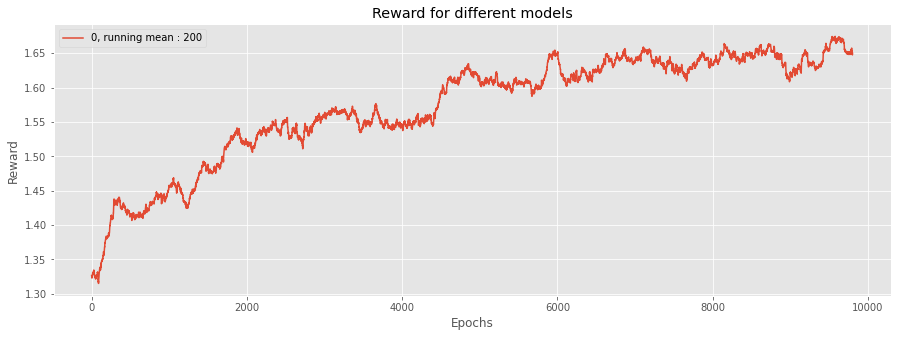

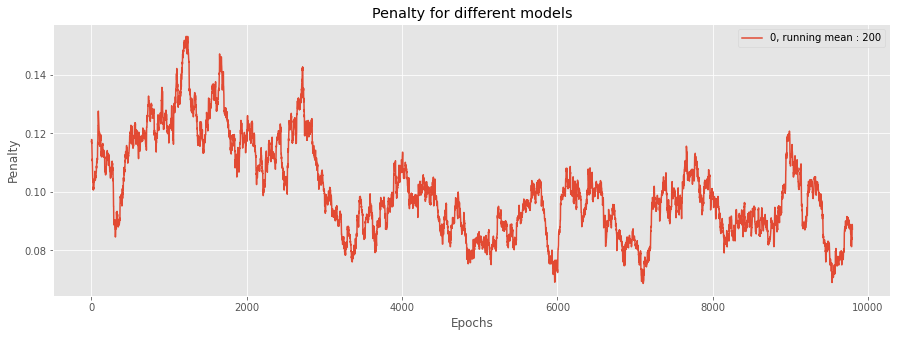

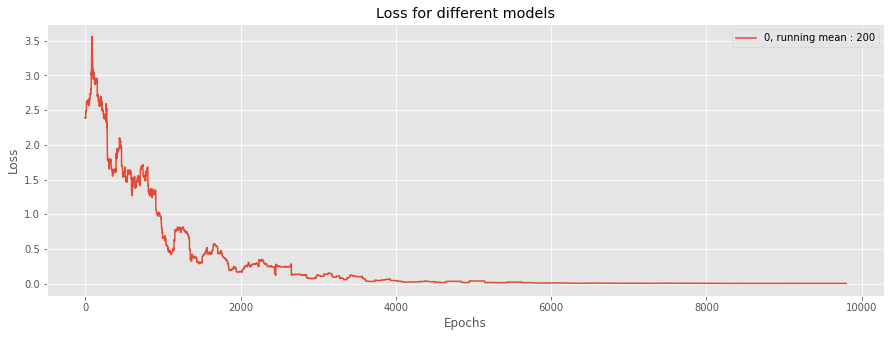

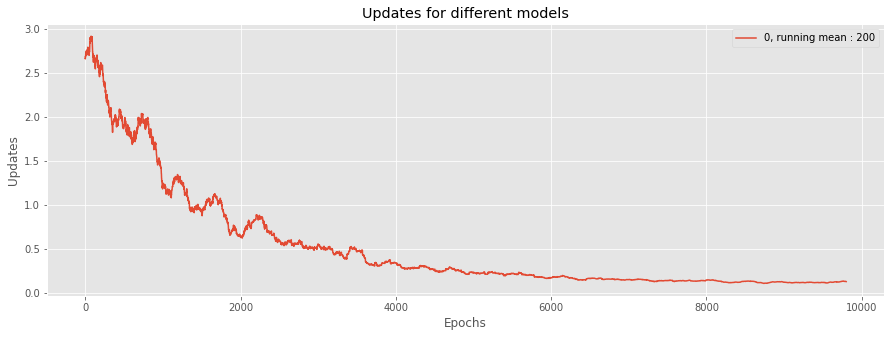

In [174]:
agents.append(test_tabular(run_mean=run_mean*10, max_iter=max_iter*10, grap=True, agent_params=agent_params_tab))
representations.append('tabular')

In [175]:
# tab = agents[0]
# _ = plot_notated_matrix(torch.from_numpy(tab.get_q_table()),  fig_size=(10, 10), print_values=True)

### Correlation and Cache

Creating Features Representations



Total number of episodes: 1000: 104914 total steps
Time to create features: 00:00:00
Time to train: 00:00:16
Average Time to train one episode: s0m16
Average Time to train one step: s0m0
Average episode size: 10.49, Standard Deviation: 10.17 and Maximum steps per episode of: 81
==>Total time to train: 00:00:16


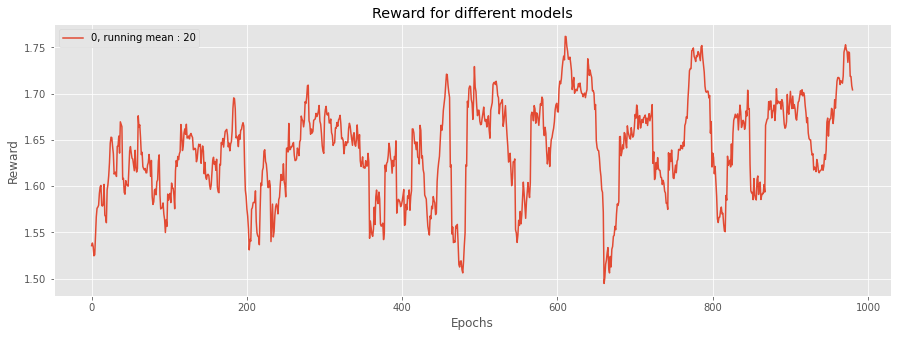

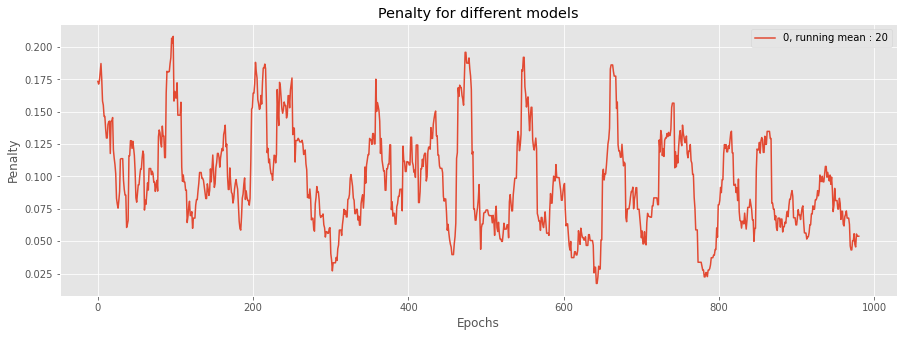

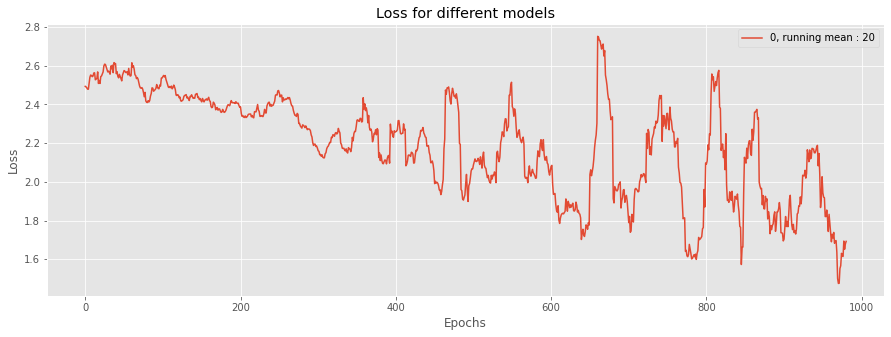

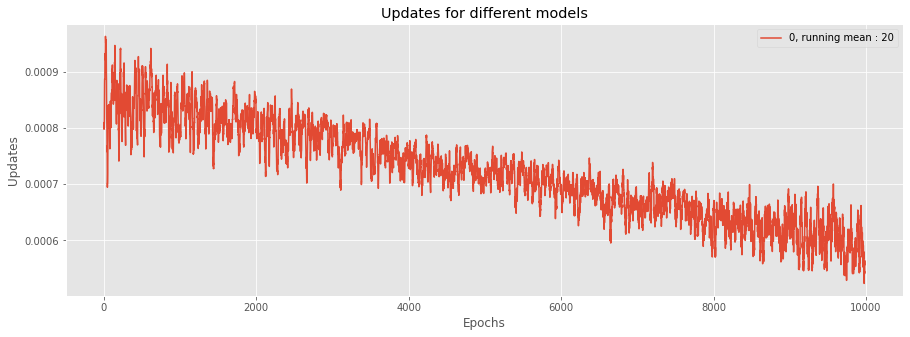

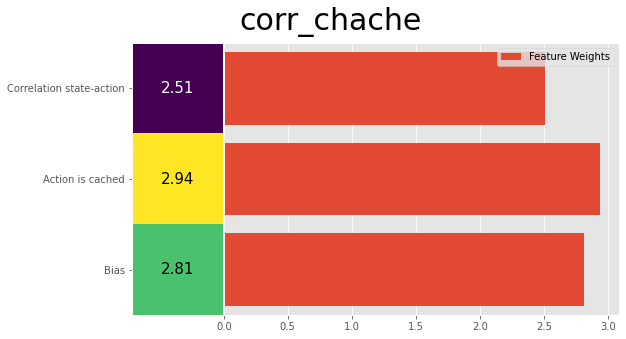

In [176]:
rep = 'corr_chache'
agents.append(test_state_action_repr(env, rep, run_mean=run_mean, grap=True, agent_params=agent_params))
representations.append(rep)
# _ = plot_notated_matrix(agents[-1].get_q_table(),  fig_size=(10, 10), print_values=True)

###Reborn

In [177]:
# rep = 'reborn'
# agents.append(test_state_action_repr(env, rep, run_mean=run_mean, grap=True, agent_params=agent_params))
# representations.append(rep)
# # _ = plot_notated_matrix(agents[-1].get_q_table(),  fig_size=(10, 10), print_values=True)

### Miriam

Creating Features Representations



Total number of episodes: 1000: 101215 total steps
Time to create features: 00:00:00
Time to train: 00:00:16
Average Time to train one episode: s0m16
Average Time to train one step: s0m0
Average episode size: 10.24, Standard Deviation: 9.99 and Maximum steps per episode of: 73
==>Total time to train: 00:00:16


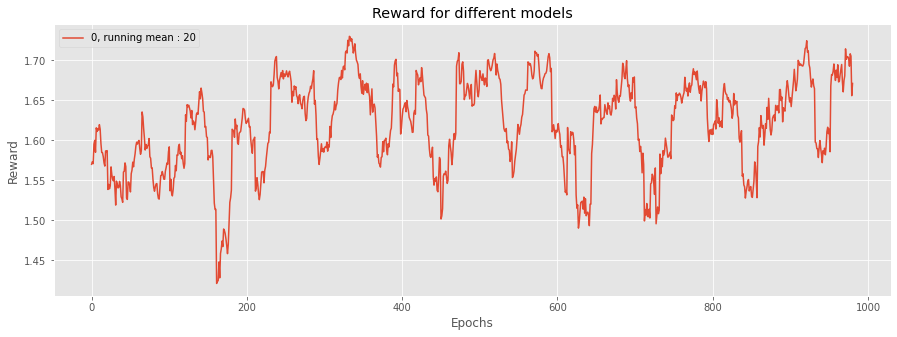

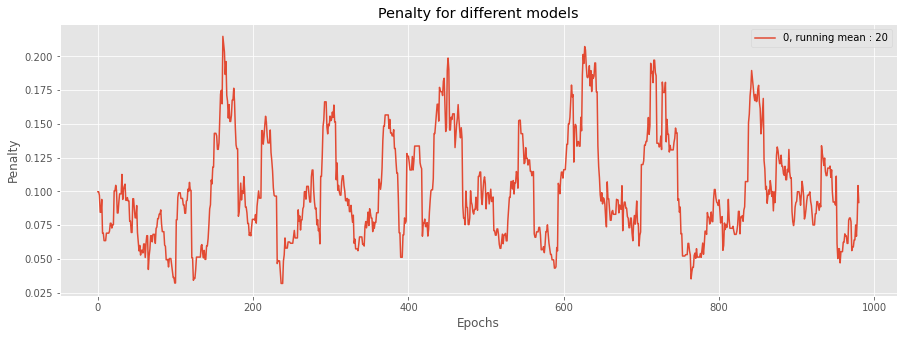

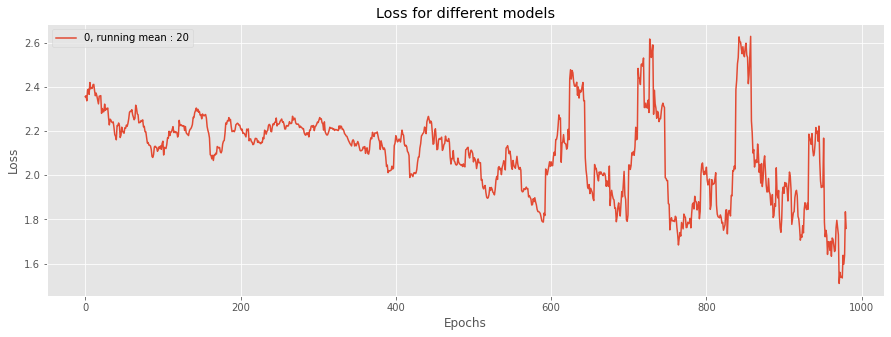

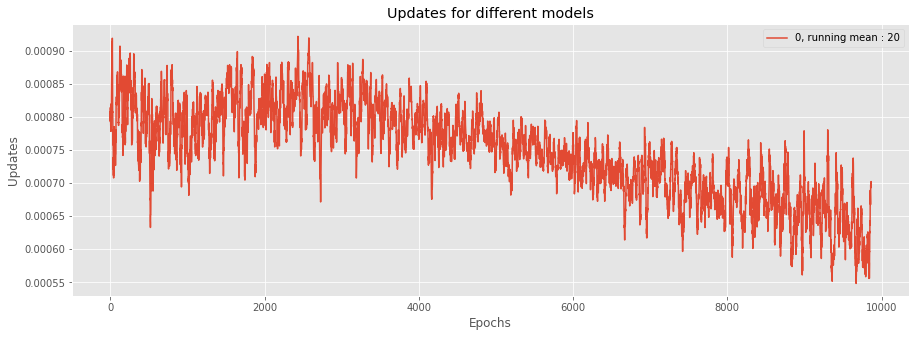

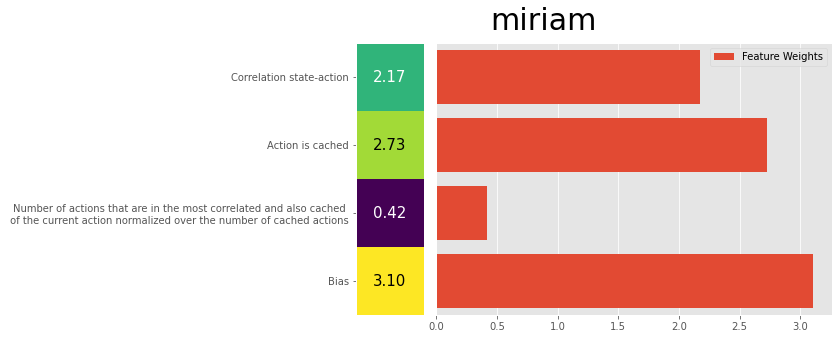

In [178]:
rep = 'miriam'
agents.append(test_state_action_repr(env, rep, run_mean=run_mean, grap=True, agent_params=agent_params))
representations.append(rep)
# _ = plot_notated_matrix(agents[-1].get_q_table(),  fig_size=(10, 10), print_values=True)

In [179]:
# test_q_table(ua, agents, representations)

## Feature Importance Comparison

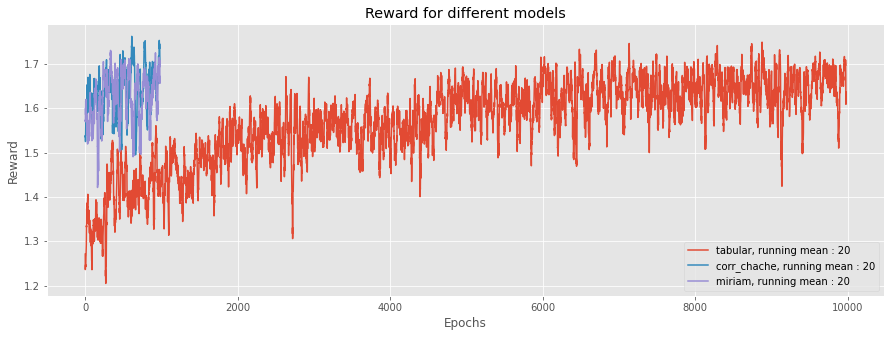

In [180]:
plot_line_charts([agent.train_data['Rewards'] for agent in agents], run_mean = run_mean, gammas = representations,name = 'Reward')

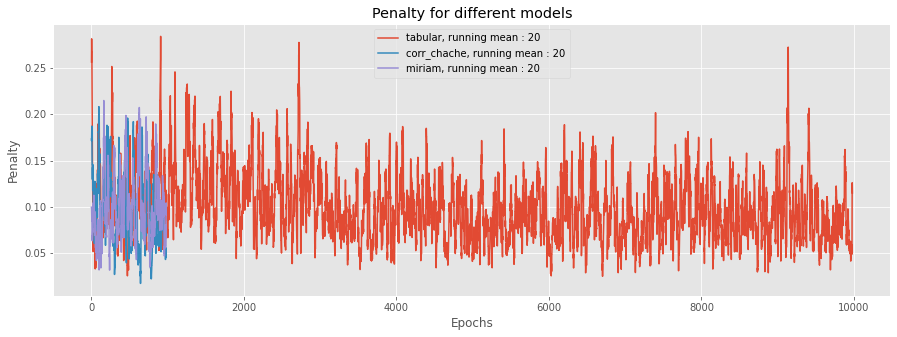

In [181]:
plot_line_charts([agent.train_data['Penalties'] for agent in agents], run_mean = run_mean, gammas = representations,name = 'Penalty')

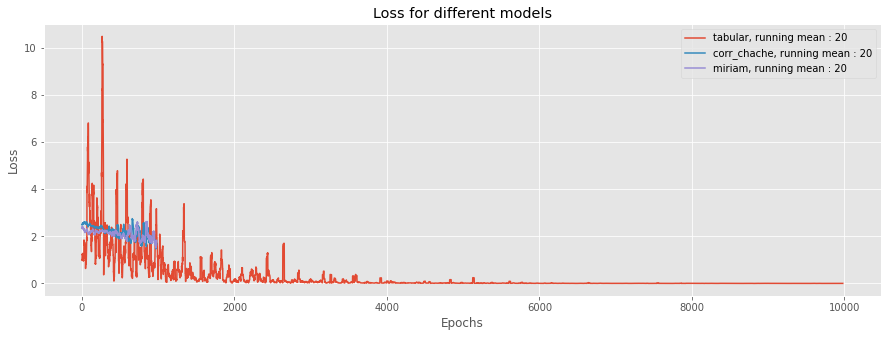

In [182]:
plot_line_charts([agent.train_data['Losses'] for agent in agents], run_mean = run_mean, gammas = representations,name = 'Loss')

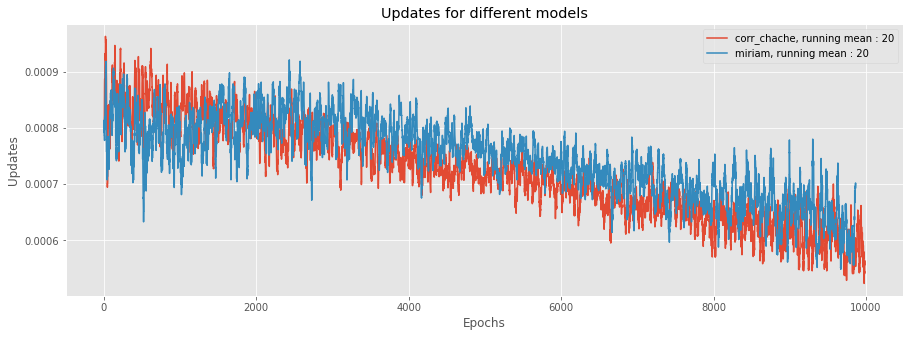

In [183]:
plot_line_charts([agent.train_data['DeltaUpdates'] for agent in agents[1:]],run_mean = run_mean, gammas = representations[1:],name = 'Updates')

## Benchmark

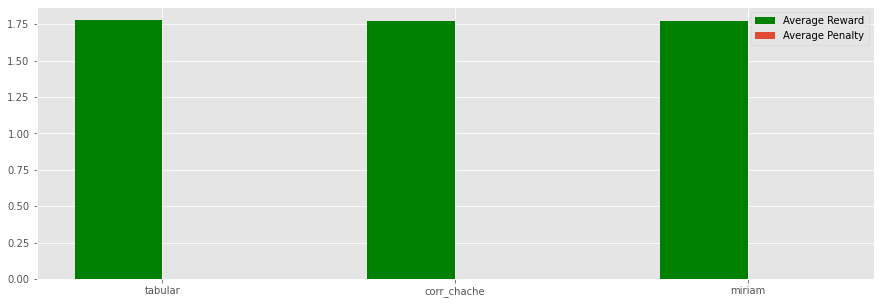

In [184]:
# agents.append(ua)
# representations.append("Optimum")
rewards, penalties, actions = benchmark(env=env, agents=agents, epochs=2000, verbose=False)
plot_benchmark(rewards, penalties, labels=representations, figsize=(15, 5))


In [185]:
rewards

[1.7796054798054457, 1.7748380419601597, 1.7721733263423365]

In [186]:
penalties

[0.0, 0.0, 0.0]

In [187]:
# fig, axs = plt.subplots(len(actions), 1, figsize=(20,5), sharey=False)
# for action, ax in zip(actions, axs):
#     ax.bar(range(n_actions), action)

##Weights

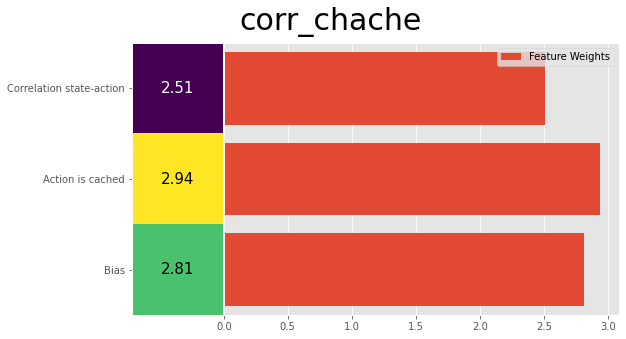

In [188]:
for i in range(1, len(representations)):
    agents[i].model.plot_weights(title=representations[i])
    plt.show()